### An example script to represent the 2-dimensional bin packing problem

In [39]:
#!pip3 install networkx matplotlib numpy h5py

In [40]:
#!pip3 install torch --index-url https://download.pytorch.org/whl/cu126
#!pip3 install torch_geometric

In [1]:
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

from torch import nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from random import shuffle
from matplotlib.patches import Rectangle

In [ ]:
dataset = []
for i in range(1, 27, 1):
    with open(f"data/gcut/gcut{i}.txt", 'r') as f:
        set = []
        for line in f:
            values = []
            for value in line.split(" "):
                values.append(float(value))
            set.append(values)
        dataset.append(set)

for set in dataset:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, (w, h, x, y) in enumerate(set[1:]):
        rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='black', facecolor='lightblue', alpha=0.7)
        ax.add_patch(rect)

        if x == int(x): x = int(x)
        if y == int(y): y = int(y)
        if w == int(w): w = int(w)
        if h == int(h): h = int(h)
        ax.text(x + w / 2, y + h / 2, f'({w}, {h})', fontsize=6, ha='center', va='center', color='black')
        ax.text(x + 5, y + 5, f'({x}, {y})', fontsize=6, color='black')

    ax.set_xlim(0, max(x + w for w, _, x, _ in set[1:]) + 1)
    ax.set_ylim(0, max(y + h for _, h, _, y in set[1:]) + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Packed Rectangles")
    ax.set_aspect('equal')

    fig.set_size_inches(18.5, 10.5)
    plt.show()
    plt.close()

In [42]:
n_epochs = 100
batch_size = 1
lr = 1e-4

in_channels=4
hidden_channels=16
out_channels=8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GIN, self).__init__()
        self.conv1_x = GINConv(
            nn.Sequential(
                nn.Linear(in_channels, hidden_channels),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU()))
        
        self.conv1_y = GINConv(
            nn.Sequential(
                nn.Linear(in_channels, hidden_channels),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU()))
        
        self.conv2_x = GINConv(
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels), 
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU()))
        
        self.conv2_y = GINConv(
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels), 
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels),
                nn.ReLU()))
        
        self.conv3_x = GINConv(
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels), 
                nn.ReLU()))
        
        self.conv3_y = GINConv(
            nn.Sequential(
                nn.Linear(hidden_channels, hidden_channels),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.Linear(hidden_channels, hidden_channels), 
                nn.ReLU()))
        
        self.lin1 = nn.Linear(hidden_channels*3*2, hidden_channels*3)
        self.lin2 = nn.Linear(hidden_channels*3, out_channels)

    def forward(self, data):
        x, edge_index_x, edge_index_y, batch = data.x, data.edge_index_x, data.edge_index_y, data.batch
        print(x.shape, edge_index_x.shape, edge_index_y.shape)
        if edge_index_x.numel() == 0:
            h1_x = x.clone()
            h2_x = x.clone()
            h3_x = x.clone()
        else:
            h1_x = self.conv1_x(x, edge_index_x)
            h2_x = self.conv2_x(h1_x, edge_index_x)
            h3_x = self.conv3_x(h2_x, edge_index_x)

        if edge_index_y.numel() == 0:
            h1_y = x.clone()
            h2_y = x.clone()
            h3_y = x.clone()
        else:
            h1_y = self.conv1_y(x, edge_index_y)
            h2_y = self.conv2_y(h1_y, edge_index_y)
            h3_y = self.conv3_y(h2_y, edge_index_y)

        h1_x = global_add_pool(h1_x, batch)
        h2_x = global_add_pool(h2_x, batch)
        h3_x = global_add_pool(h3_x, batch)

        h1_y = global_add_pool(h1_y, batch)
        h2_y = global_add_pool(h2_y, batch)
        h3_y = global_add_pool(h3_y, batch)

        h = torch.cat((h1_x, h2_x, h3_x, h1_y, h2_y, h3_y), dim=1)

        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)

In [44]:
class BinPackingGraph:
    def __init__(self, items, container_width):
        self.packing = []
        self.container_width = container_width
        
        self.G_x = nx.Graph()
        self.G_y = nx.Graph()

        self.bottom_left_packing(items)
        self.construct_graphs()
        
    def bottom_left_packing(self, items):
        is_packable = False
        for i, (w1, _) in enumerate(items):
            for j, (w2, _) in enumerate(items):
                if i == j:
                    continue

                if w1 + w2 <= self.container_width:
                    is_packable = True
                    break
                
        if not is_packable:
            for i, (_, h1) in enumerate(items):
                for j, (w2, _) in enumerate(items):
                    if i == j:
                        continue

                    if h1 + w2 <= self.container_width:
                        items[i] = (items[i][1], items[i][0])
                        is_packable = True
                        break
                
                if is_packable:
                    break

        sorted_items_with_indices = sorted(enumerate(items), key=lambda x: (-x[1][1], -x[1][0]))
        x_cursor, y_cursor = 0, 0
        max_row_height = 0
        
        for i, (w, h) in sorted_items_with_indices:
            if x_cursor + w > self.container_width:
                x_cursor = 0
                y_cursor += max_row_height
                max_row_height = 0
            
            self.packing.append((i, x_cursor, y_cursor, w, h))
            x_cursor += w
            max_row_height = max(max_row_height, h)

    def random_packing(self, items):
        is_packable = False
        for i, (w1, _) in enumerate(items):
            for j, (w2, _) in enumerate(items):
                if i == j:
                    continue

                if w1 + w2 <= self.container_width:
                    is_packable = True
                    break
                
        if not is_packable:
            for i, (_, h1) in enumerate(items):
                for j, (w2, _) in enumerate(items):
                    if i == j:
                        continue

                    if h1 + w2 <= self.container_width:
                        items[i] = (items[i][1], items[i][0])
                        is_packable = True
                        break
                
                if is_packable:
                    break
        
        shuffled_items = items.copy()
        shuffle(shuffled_items)
        x_cursor, y_cursor = 0, 0
        max_row_height = 0

        for w, h in shuffled_items:
            if x_cursor + w > self.container_width:
                x_cursor = 0
                y_cursor += max_row_height
                max_row_height = 0
            
            self.packing.append((x_cursor, y_cursor, w, h))
            x_cursor += w
            max_row_height = max(max_row_height, h)
        
    def construct_graphs(self):
        self.G_x = nx.Graph()
        self.G_y = nx.Graph()

        for i, x1, y1, w1, h1 in self.packing:
            self.G_x.add_node(i, pos=(x1, y1), size=(w1, h1))
            self.G_y.add_node(i, pos=(x1, y1), size=(w1, h1))

            x1_end = x1 + w1
            y1_end = y1 + h1
            
            for j, x2, y2, w2, h2 in self.packing:
                if i == j:
                    continue
                
                x2_end = x2 + w2
                y2_end = y2 + h2

                if not (x1_end <= x2 or x2_end <= x1):
                    self.G_y.add_edge(i, j)
                
                if not (y1_end <= y2 or y2_end <= y1):
                    self.G_x.add_edge(i, j)

    def nx_to_pyg(self):
        num_nodes_x = self.G_x.number_of_nodes()
        x = torch.tensor(
            [[self.G_x.nodes[i]['pos'][0], self.G_x.nodes[i]['pos'][1], self.G_x.nodes[i]['size'][0], self.G_x.nodes[i]['size'][1]] for i in range(num_nodes_x)], 
            dtype=torch.float)

        edge_index_x = torch.tensor(list(self.G_x.edges), dtype=torch.long).t().contiguous()
        edge_index_y = torch.tensor(list(self.G_y.edges), dtype=torch.long).t().contiguous()

        return Data(x=x, edge_index_x=edge_index_x, edge_index_y=edge_index_y)

    def plot_packing(self):
        fig, ax = plt.subplots(figsize=(12, 6))

        for i, x, y, w, h in self.packing:
            rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='black', facecolor='lightblue', alpha=0.7)
            ax.add_patch(rect)

            if x == int(x): x = int(x)
            if y == int(y): y = int(y)
            if w == int(w): w = int(w)
            if h == int(h): h = int(h)
            ax.text(x + w / 2, y + h / 2, f'({w}, {h})', fontsize=6, ha='center', va='center', color='black')

        ax.set_xlim(0, max(x + w for _, x, _, w, _ in self.packing) + 1)
        ax.set_ylim(0, max(y + h for _, _, y, _, h in self.packing) + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Packed Rectangles")
        ax.set_aspect('equal')

        # plt.gca().invert_yaxis()
        fig.set_size_inches(18.5, 10.5)
        plt.show()
        plt.close()

    def plot_graphs(self):
        fig = plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        nx.draw(self.G_x, with_labels=True)
        plt.title("G_x")
        # plt.show()
        # plt.close()

        # plt.subplot(1, 2, 2)
        plt.axvline(x = 5, color = 'b')
        
        # plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 2)
        nx.draw(self.G_y, with_labels=True)
        plt.title("G_y")

        fig.set_size_inches(18.5, 10.5)
        plt.show()
        plt.close()

In [45]:
items_list = [
    [(3, 2), (5, 3), (2, 4), (4, 2), (3, 3)],
    [(2, 2), (3, 4), (4, 2), (1, 5), (3, 3)],
    [(8, 7), (7, 2), (6, 6), (9, 1), (7, 4)],
    [(6, 1), (6, 4), (3, 5), (4, 8), (3, 7)],
    [(3, 2), (5, 3), (2, 4), (4, 2), (3, 3)]
]

container_width = 10

dataset = []
bps = []
for items in items_list:
    bp = BinPackingGraph(items, container_width)
    dataset.append(bp.nx_to_pyg())
    bps.append(bp)

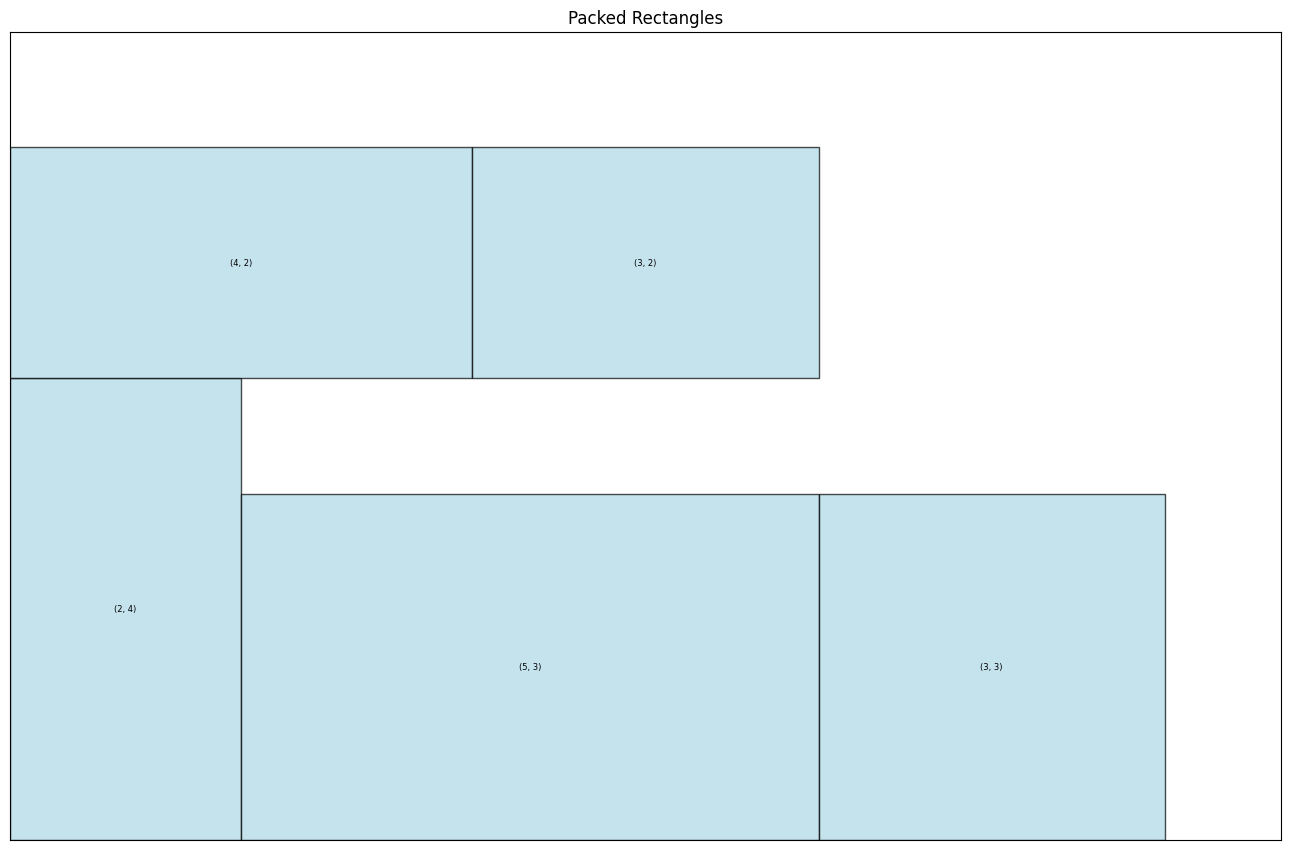

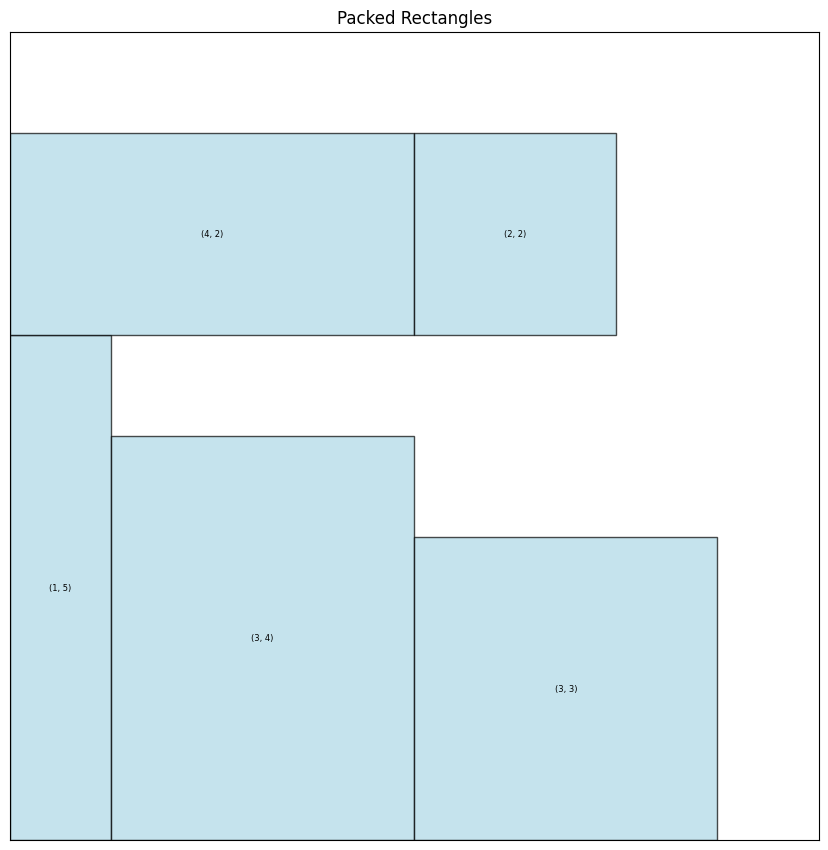

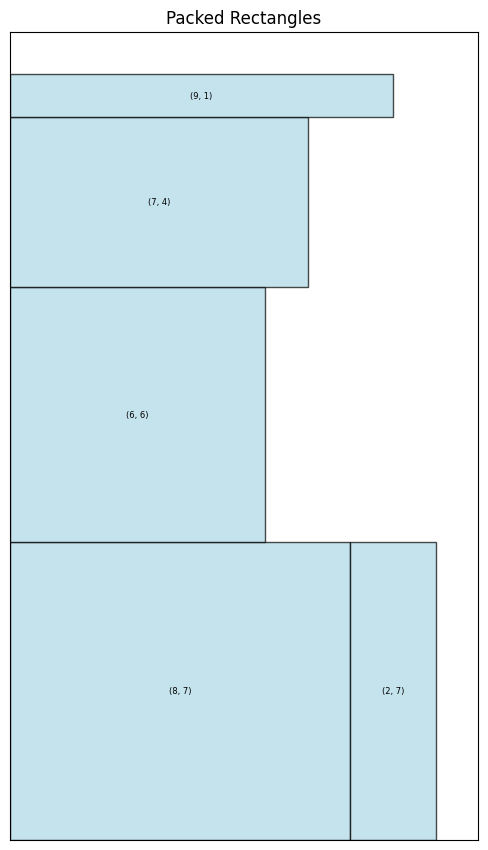

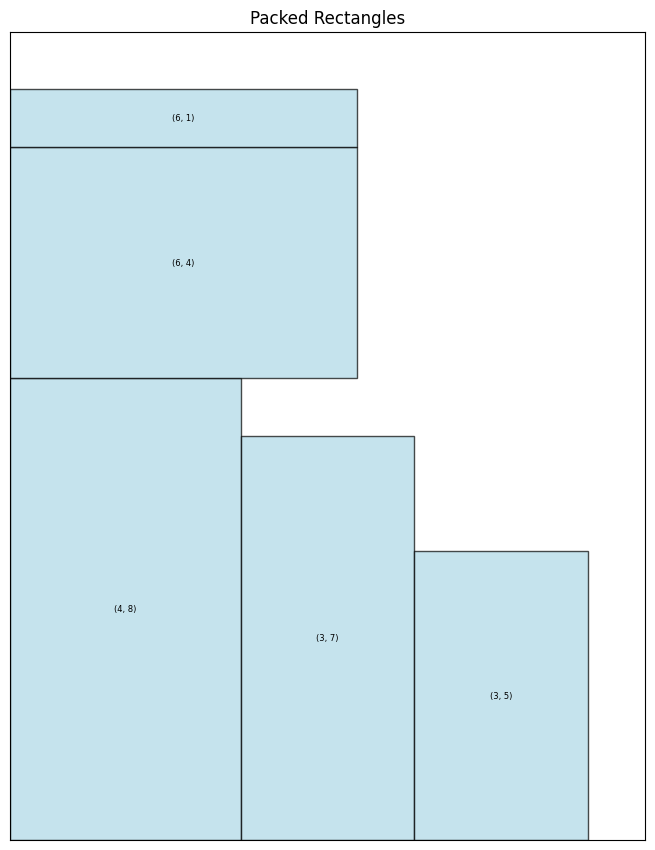

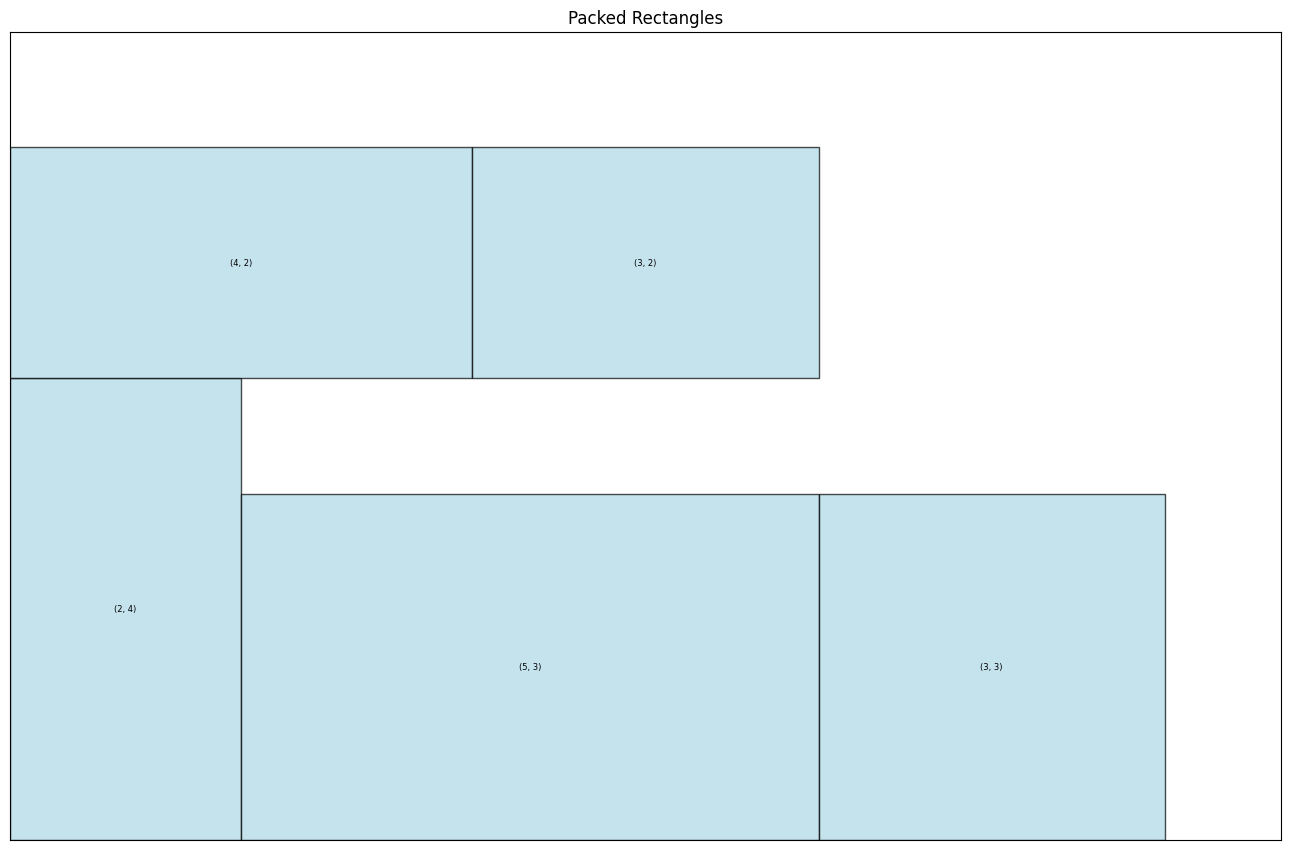

In [46]:
for bp in bps:
    bp.plot_packing()

<Figure size 640x480 with 0 Axes>

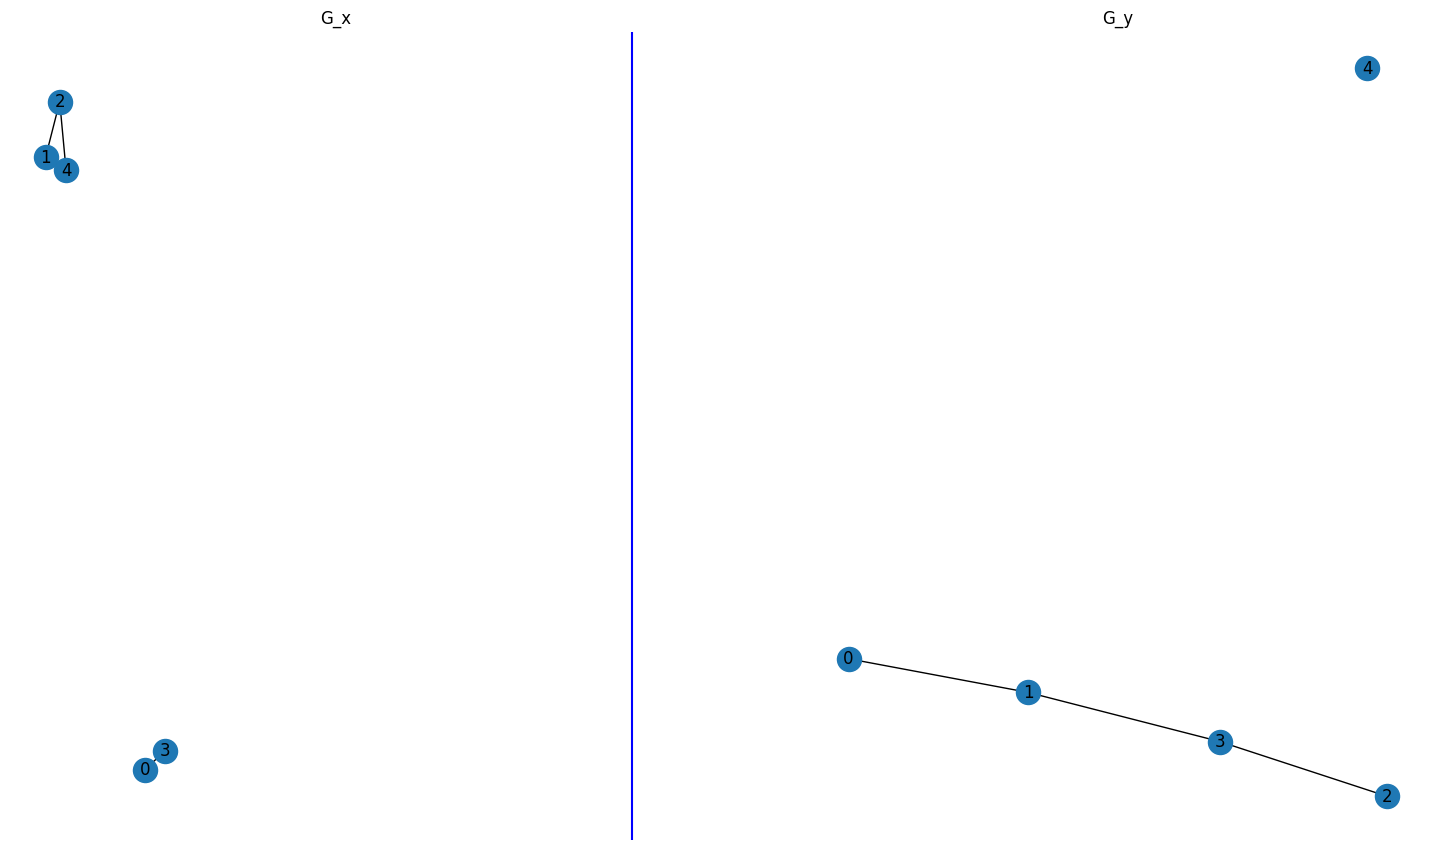

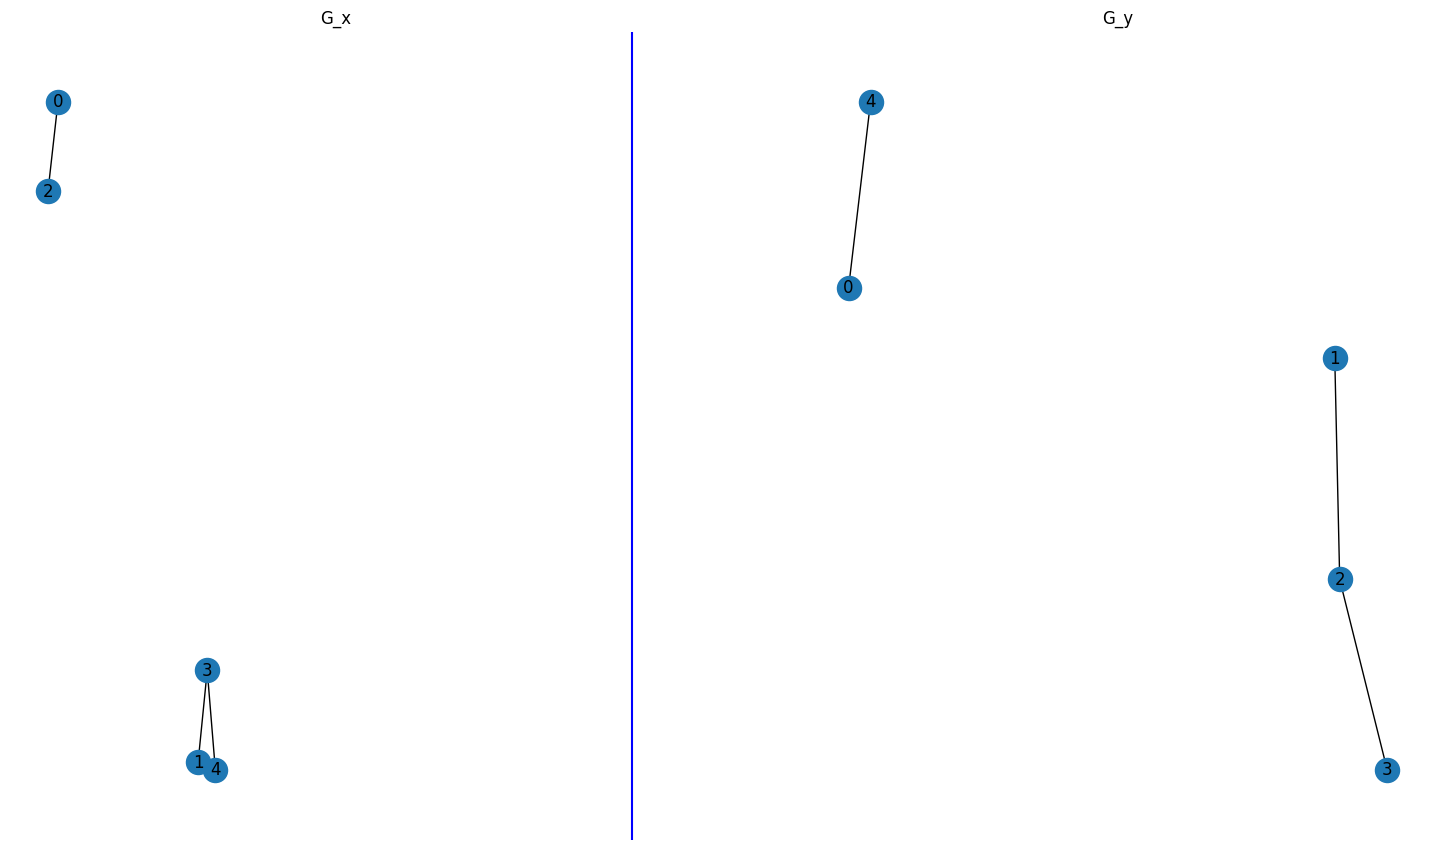

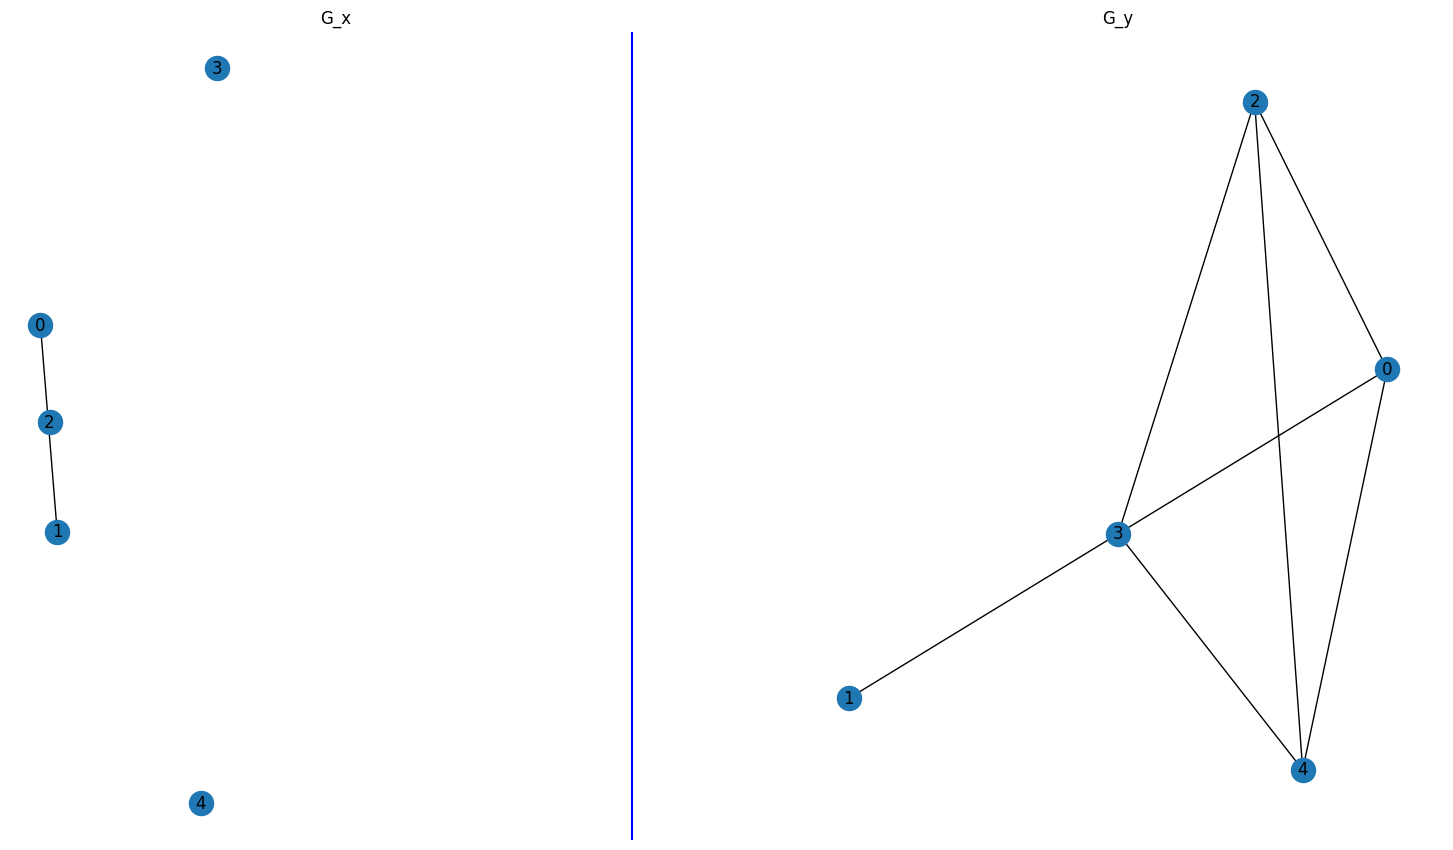

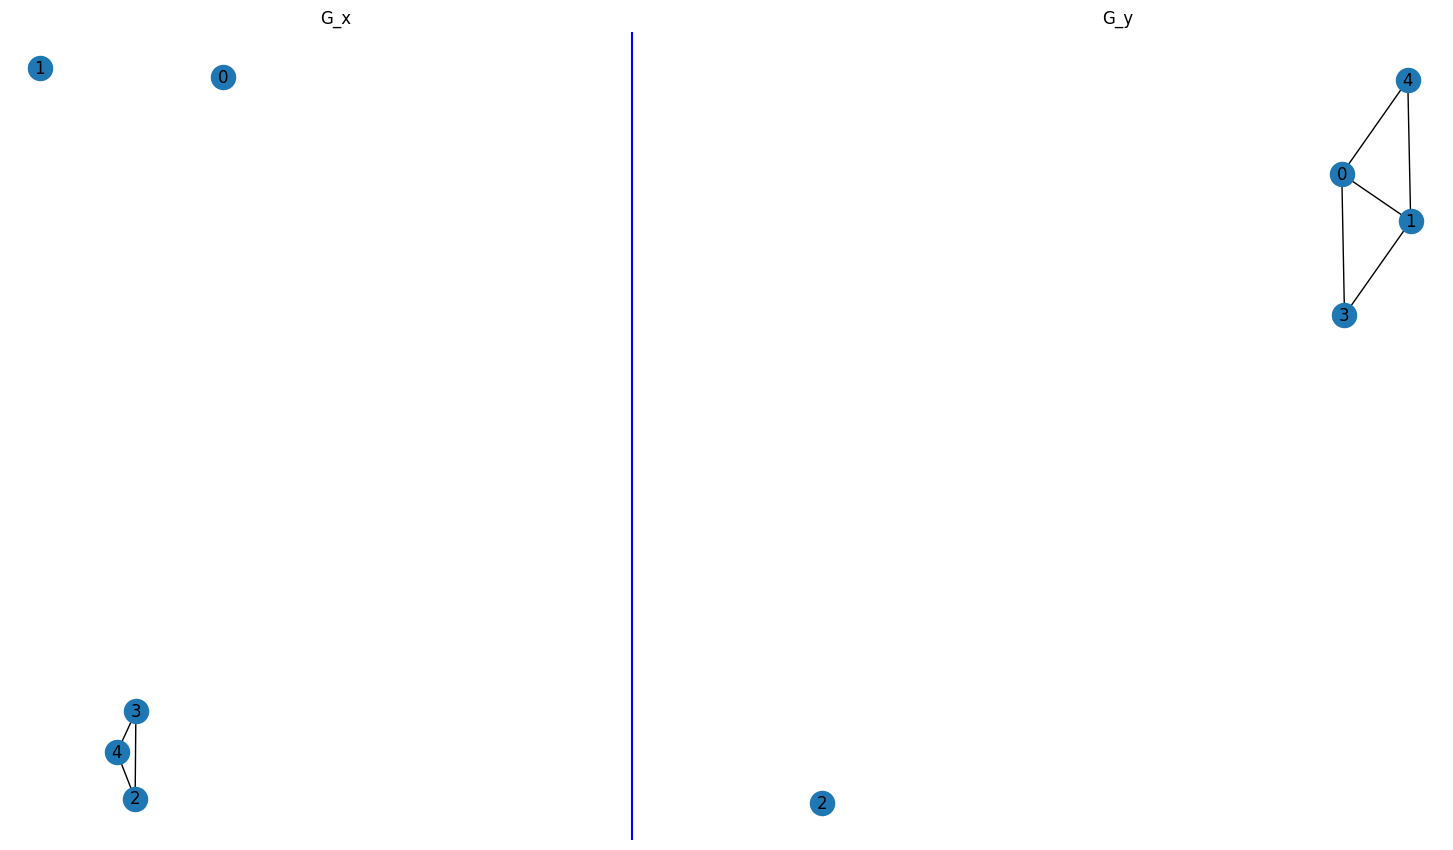

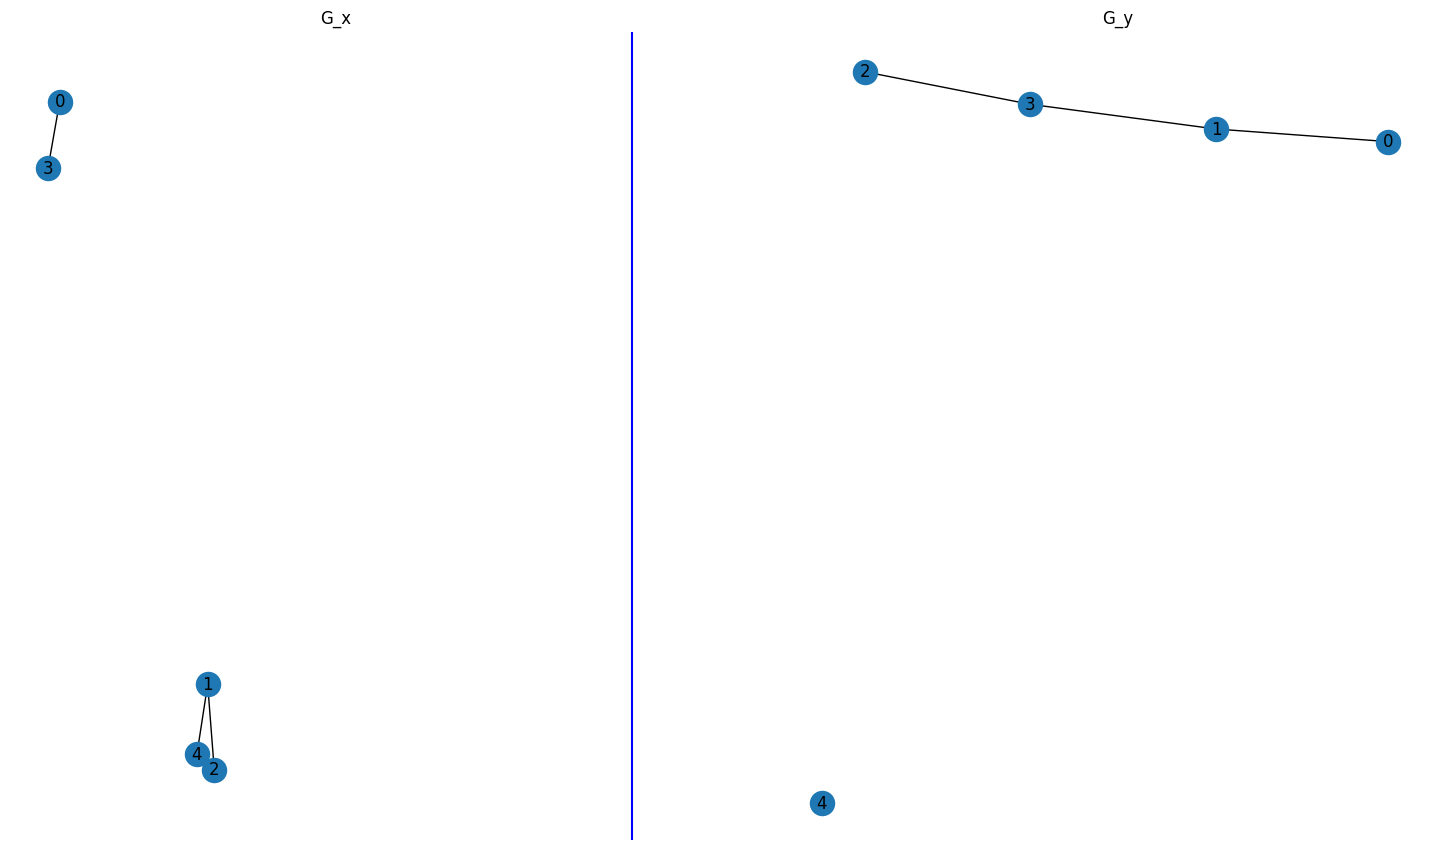

In [47]:
plt.tight_layout()

for bp in bps:
    bp.plot_graphs()

In [48]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = GIN(in_channels=4, hidden_channels=16, out_channels=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

def train(model, loader, optimizer, criterion, epochs=n_epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
        break
        #     loss = criterion(output, data.y)
        #     loss.backward()
        #     optimizer.step()
        #     total_loss += loss.item()
        # print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader)}")

In [49]:
train(model, loader, optimizer, criterion, n_epochs)

torch.Size([5, 4]) torch.Size([2, 1]) torch.Size([2, 7])
torch.Size([5, 4]) torch.Size([2, 4]) torch.Size([2, 3])
torch.Size([5, 4]) torch.Size([2, 3]) torch.Size([2, 5])
torch.Size([5, 4]) torch.Size([2, 4]) torch.Size([2, 3])
torch.Size([5, 4]) torch.Size([2, 4]) torch.Size([2, 3])
